# Model Input Data Preparation

In this notebook, we will prepare five essential files to construct a foundational class called `DroughtDataset`, based on the `TabularDataset` class from the [torch-spatiotemporal library](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/datasets_prototypes.html#tsl.datasets.prototypes.TabularDataset). 

In the next notebook (`6.training.ipynb`), we will utilize this class to create a proper structure for feeding data into deep learning models.

The files we will prepare include:

- **target**: Stores our target variable data.
- **mask**: Specifies areas or time periods with missing or irrelevant data.
- **covariates**: Contains feature data that will serve as model inputs.
- **metadata**: Provides additional information about each data point, such as location and time-specific attributes.
- **distance matrix**: Contains distances between spatial points, which supports spatial relationship modeling.


## Load data

In [2]:
import xarray as xr
import numpy as np

# Load the dataset
ds = xr.open_dataset('soil-water-forecasting/modeling-pipeline/data/04_feature/features.nc', chunks="auto")

In [3]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:                (valid_time: 551, latitude: 180, longitude: 360)
Coordinates:
  * valid_time             (valid_time) datetime64[ns] 4kB 1979-01-01 ... 202...
  * latitude               (latitude) int64 1kB -90 -89 -88 -87 ... 86 87 88 89
  * longitude              (longitude) int64 3kB 0 1 2 3 4 ... 356 357 358 359
    month                  (valid_time) int64 4kB dask.array<chunksize=(551,), meta=np.ndarray>
Data variables: (12/27)
    swvl1                  (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cl                     (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cvh                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tvh                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    asn                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    sst                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ...                     ...
    ro                     (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp                     (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    pev                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp_pnp                 (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp_std_anomaly_binary  (valid_time, latitude, longitude) int64 286MB dask.array<chunksize=(430, 139, 279), meta=np.ndarray>
    season                 (valid_time, latitude, longitude) int32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

## Target

The `target` stores values for the target variable, `swvl1`, over time and location.



In [4]:
# Define the target variables to extract from the dataset
targets = ['tp']
data_arrays = [ds[var] for var in targets]

# Flatten latitude and longitude into a single "node" dimension
# This combines the latitude and longitude coordinates as one "node" dimension
data_arrays_flattened = [da.stack(node=('latitude', 'longitude')) for da in data_arrays]

# Convert each DataArray to a numpy array and add a new channel dimension
# This results in an array with shape (time, nodes, channels) for the target data
target = np.stack([da.to_numpy() for da in data_arrays_flattened], axis=-1)


In [5]:
target

array([[[0.03814697],
        [0.03814697],
        [0.03814697],
        ...,
        [0.33950806],
        [0.3376007 ],
        [0.3376007 ]],

       [[0.08201599],
        [0.08201599],
        [0.08201599],
        ...,
        [0.15068054],
        [0.1487732 ],
        [0.1449585 ]],

       [[0.38719177],
        [0.38719177],
        [0.38719177],
        ...,
        [0.2861023 ],
        [0.2822876 ],
        [0.27656555]],

       ...,

       [[0.16212463],
        [0.16212463],
        [0.16212463],
        ...,
        [0.5683899 ],
        [0.57029724],
        [0.5722046 ]],

       [[0.20599365],
        [0.20599365],
        [0.20599365],
        ...,
        [1.543045  ],
        [1.5392303 ],
        [1.5354156 ]],

       [[0.24700165],
        [0.24700165],
        [0.24700165],
        ...,
        [0.6904602 ],
        [0.6875992 ],
        [0.68473816]]], dtype=float32)

In [6]:
# Save as .npy file
np.save('soil-water-forecasting/modeling-pipeline/data/05_model_input/target.npy', target)

## Mask 

Boolean mask denoting if values in target are valid (True) or not (False).

In [7]:
mask = np.where(~np.isnan(target), 1, 0)

In [8]:
mask

array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]])

In [21]:
# Save as .npy file
np.save('soil-water-forecasting/modeling-pipeline/data/05_model_input/mask.npy', mask)

## Covariates 

The `covariates` stores values for the features variables over time and location.

In [9]:
import numpy as np

# Define covariates: Relevant variables from the dataset to be used as features in the model
variables = [
    # 'swvl1',           # Soil water in layer 1
    # 'cl',              # Lake cover
    # 'cvh',             # High vegetation cover
    # 'tvh',             # Type of high vegetation
    # 'asn',             # Snow albedo
    'sst',             # Sea surface temperature
    # 'slt',             # Soil type
    # 'lai_hv',          # Leaf area index, high vegetation
    'tclw',            # Total column cloud liquid water
    'tciw',            # Total column cloud ice water
    'z',               # Geopotential
    'sp',              # Surface pressure
    'msl',             # Mean sea level pressure
    'tcc',             # Total cloud cover
    'u10',             # 10 metre U wind component
    'v10',             # 10 metre V wind component
    # 't2m',             # 2 metre temperature high correlation with d2m
    'd2m',             # 2 metre dewpoint temperature
    'lsm',             # Land-sea mask
    'si10',            # 10 metre wind speed
    'e',               # Evaporation
    'ro',              # Runoff
    # 'tp',              # Total precipitation
    'pev',             # Potential evaporation
    'season',           # Season (single temporal feature)
    # 'tp_std_anomaly'   # Total precipitation standarized anamoalies
]

# Extract the defined covariate variables from the dataset
data_arrays = [ds[var] for var in variables]

# Flatten latitude and longitude into a single "node" dimension
# This combines the spatial coordinates into one dimension labeled "node"
data_arrays_flattened = [da.stack(node=('latitude', 'longitude')) for da in data_arrays]

# Convert each DataArray to a numpy array and add a new channel dimension
# The resulting array has the shape (time, nodes, channels), ready for model input
covariates = np.stack([da.to_numpy() for da in data_arrays_flattened], axis=-1)

# Replace NaN values with 0 to handle missing data
covariates = np.nan_to_num(covariates, nan=0.0)


In [10]:
covariates

array([[[ 0.00000000e+00,  1.52587891e-04,  1.70898438e-03, ...,
          0.00000000e+00, -6.25960529e-02,  1.00000000e+00],
        [ 0.00000000e+00,  1.52587891e-04,  1.70898438e-03, ...,
          0.00000000e+00, -6.25960529e-02,  1.00000000e+00],
        [ 0.00000000e+00,  1.52587891e-04,  1.70898438e-03, ...,
          0.00000000e+00, -6.25960529e-02,  1.00000000e+00],
        ...,
        [ 2.71460205e+02,  8.39233398e-04,  1.35383606e-02, ...,
          0.00000000e+00,  1.08033419e-04,  1.00000000e+00],
        [ 2.71460205e+02,  8.39233398e-04,  1.34887695e-02, ...,
          0.00000000e+00,  1.08033419e-04,  1.00000000e+00],
        [ 2.71460205e+02,  8.23974609e-04,  1.34353638e-02, ...,
          0.00000000e+00,  1.08033419e-04,  1.00000000e+00]],

       [[ 0.00000000e+00,  7.62939453e-05,  4.45938110e-03, ...,
          0.00000000e+00, -1.95316970e-02,  1.00000000e+00],
        [ 0.00000000e+00,  7.62939453e-05,  4.45938110e-03, ...,
          0.00000000e+00, -1.95316970e

In [11]:
# Save as .npy file
np.save('soil-water-forecasting/modeling-pipeline/data/05_model_input/covariates.npy', covariates)

## Metadata

The metadata store values for the latitude and longitude of each specific location (node).







In [14]:
import pandas as pd
import os

def generate_and_save_metadata(df: pd.DataFrame, lat_col: str = 'lat', lon_col: str = 'lon', save_directory: str = None) -> pd.DataFrame:
    """
    Generates metadata from a given DataFrame by identifying unique latitude and longitude
    combinations and assigning a unique node ID to each combination. The metadata is then
    saved to a specified Parquet file.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - lat_col (str): The name of the column containing latitude data.
    - lon_col (str): The name of the column containing longitude data.
    - save_directory (str, optional): The directory where the metadata file will be saved. If None, 
                                      the file will be saved in the current working directory.

    Returns:
    - pd.DataFrame: A DataFrame containing the metadata with latitude, longitude, and 'node_id' as columns.
    """
    # Ensure the DataFrame contains necessary columns
    if lat_col not in df.columns or lon_col not in df.columns:
        raise ValueError(f"DataFrame must contain '{lat_col}' and '{lon_col}' columns.")

    # Create a unique node ID for each unique latitude-longitude combination
    unique_lat_lon = df[[lat_col, lon_col]].drop_duplicates().reset_index(drop=True)
    unique_lat_lon['node_id'] = unique_lat_lon.index

    # Create the metadata DataFrame
    metadata = unique_lat_lon.set_index('node_id')

    # Handle save directory and save metadata to Parquet file
    if save_directory:
        os.makedirs(save_directory, exist_ok=True)  # Create directory if it doesn't exist
        file_path = os.path.join(save_directory, "metadata.parquet")
    else:
        file_path = "metadata.parquet"  # Save in the current working directory

    metadata.to_parquet(file_path)
    print(f"Metadata file saved at: {file_path}")

    return metadata


In [15]:
import pandas as pd
import os

# Assume you've already stacked your data arrays as 'data_arrays_flattened'
# We'll use one of the flattened DataArrays to extract the node information
da_flattened = data_arrays_flattened[0]  # Using the first variable for example

# Get the MultiIndex from the 'node' dimension
node_index = da_flattened.indexes['node']

# Extract latitude and longitude from the MultiIndex
latitudes = node_index.get_level_values('latitude').values
longitudes = node_index.get_level_values('longitude').values

# Create a DataFrame with 'lat' and 'lon' columns
df = pd.DataFrame({
    'lat': latitudes,
    'lon': longitudes
})

# Now use your 'generate_and_save_metadata' function
metadata = generate_and_save_metadata(
    df,
    lat_col='lat',
    lon_col='lon',
    save_directory='soil-water-forecasting/modeling-pipeline/data/05_model_input/'
)


Metadata file saved at: soil-water-forecasting/modeling-pipeline/data/05_model_input/metadata.parquet


<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.Tensor size changed, may indicate binary incompatibility. Expected 64 from C header, got 80 from PyObject


In [16]:
import pandas as pd
metadata = pd.read_parquet("soil-water-forecasting/modeling-pipeline/data/05_model_input/metadata.parquet")

In [17]:
metadata

lat  lon
node_id          
0        -90    0
1        -90    1
2        -90    2
3        -90    3
4        -90    4
...      ...  ...
64795     89  355
64796     89  356
64797     89  357
64798     89  358
64799     89  359

[64800 rows x 2 columns]

In [18]:
# Converting the DataFrame to a numpy ndarray
metadata_array = metadata.to_numpy()

In [19]:
# Save as .npy file
np.save('soil-water-forecasting/modeling-pipeline/data/05_model_input/metadata.npy', metadata_array)

## Distance matrix 

The distance_matrix stores values for the geographical distances between locations (nodes).


In [20]:
import pandas as pd
metadata = pd.read_parquet("drought-forecasting/modeling-pipeline/data/05_model_input/metadata.parquet")

In [21]:
metadata

lat  lon
node_id          
0        -90    0
1        -90    1
2        -90    2
3        -90    3
4        -90    4
...      ...  ...
64795     89  355
64796     89  356
64797     89  357
64798     89  358
64799     89  359

[64800 rows x 2 columns]

here min 70GB of RAM for this :( i am looking for new alternatve. 3 min 38 sek

In [22]:
from tsl.ops.similarities import geographical_distance
# Calculate geographical distances with coordinates converted to radians.
distance_matrix = geographical_distance(metadata, to_rad=True).values

In [23]:
distance_matrix

array([[0.00000000e+00, 6.80864854e-15, 1.36167786e-14, ...,
        1.99039194e+04, 1.99039194e+04, 1.99039194e+04],
       [6.80864854e-15, 0.00000000e+00, 6.80864854e-15, ...,
        1.99039194e+04, 1.99039194e+04, 1.99039194e+04],
       [1.36167786e-14, 6.80864854e-15, 0.00000000e+00, ...,
        1.99039194e+04, 1.99039194e+04, 1.99039194e+04],
       ...,
       [1.99039194e+04, 1.99039194e+04, 1.99039194e+04, ...,
        0.00000000e+00, 1.94059711e+00, 3.88104648e+00],
       [1.99039194e+04, 1.99039194e+04, 1.99039194e+04, ...,
        1.94059711e+00, 0.00000000e+00, 1.94059711e+00],
       [1.99039194e+04, 1.99039194e+04, 1.99039194e+04, ...,
        3.88104648e+00, 1.94059711e+00, 0.00000000e+00]])

In [24]:
import numpy as np

# Save as .npy file
np.save('drought-forecasting/modeling-pipeline/data/05_model_input/distance_matrix.npy', distance_matrix)

# Test and setting up connectivity 

Below is a test to verify the functionality of the class.







In [2]:
from typing import Optional, Union, List
import numpy as np
import pandas as pd 

from tsl.datasets.prototypes import TabularDataset
from tsl.ops.similarities import gaussian_kernel

class Dataset(TabularDataset):

    similarity_options = {'distance', 'grid'}

    def __init__(self,
                 root: str = None
                 ):

        self.root = root

        # Load data
        target, mask, u, dist, metadata = self.load()

        covariates = {
            'u': (u),
            'metadata' : (metadata),
            'distances': (dist)
        }

        super().__init__(target=target,
                         mask=mask,
                         covariates=covariates,
                         similarity_score='distance',
                         temporal_aggregation='mean',
                         spatial_aggregation='mean',
                         name='Dataset')

    def load(self):
        """
        Load data from files.

        Returns:
            tuple: Containing target, mask, covariates, distances, and metadata.
        """
        target_path = f"{self.root}target.npy"
        mask_path = f"{self.root}mask.npy"
        dist_path = f"{self.root}distance_matrix.npy"
        covariates_path = f"{self.root}covariates.npy"
        metadata_path = f"{self.root}metadata.npy"

        target = np.load(target_path)
        mask = np.load(mask_path)
        u = np.load(covariates_path)
        dist = np.load(dist_path)
        metadata = np.load(metadata_path)

        return target, mask, u, dist, metadata


    def compute_similarity(self, method: str, **kwargs):
        """
        Compute similarity matrix based on the specified method.

        Args:
            method (str): The similarity computation method ('distance' or 'grid').
            **kwargs: Additional keyword arguments for similarity computation.

        Returns:
            numpy.ndarray: Computed similarity matrix.

        Raises:
            ValueError: If an unknown similarity method is provided.
        """
        if method == "distance":
            # Calculate a Gaussian kernel similarity from the distance matrix, using a default or provided 'theta'
            theta = kwargs.get('theta', np.std(self.distances))
            return gaussian_kernel(self.distances, theta=theta)
        elif method == "grid":
            dist = self.distances.copy()
            dist[dist > 16] = np.inf  # keep only grid edges
            theta = kwargs.get('theta', 20)
            return gaussian_kernel(dist, theta=theta)
        else:
            raise ValueError(f"Unknown similarity method: {method}")

In [3]:
dataset = Dataset(root='soil-water-forecasting/modeling-pipeline/data/05_model_input/')

In [4]:
dataset.metadata

array([[-90,   0],
       [-90,   1],
       [-90,   2],
       ...,
       [ 89, 357],
       [ 89, 358],
       [ 89, 359]], dtype=int32)

In [5]:
dataset.distances

array([[0.0000000e+00, 6.8086486e-15, 1.3616779e-14, ..., 1.9903920e+04,
        1.9903920e+04, 1.9903920e+04],
       [6.8086486e-15, 0.0000000e+00, 6.8086486e-15, ..., 1.9903920e+04,
        1.9903920e+04, 1.9903920e+04],
       [1.3616779e-14, 6.8086486e-15, 0.0000000e+00, ..., 1.9903920e+04,
        1.9903920e+04, 1.9903920e+04],
       ...,
       [1.9903920e+04, 1.9903920e+04, 1.9903920e+04, ..., 0.0000000e+00,
        1.9405971e+00, 3.8810465e+00],
       [1.9903920e+04, 1.9903920e+04, 1.9903920e+04, ..., 1.9405971e+00,
        0.0000000e+00, 1.9405971e+00],
       [1.9903920e+04, 1.9903920e+04, 1.9903920e+04, ..., 3.8810465e+00,
        1.9405971e+00, 0.0000000e+00]], dtype=float32)

also here min 110GB of RAM for this :( i am looking for new alternatve 2m 31 s

In [6]:
# Adjust connectivity to reduce the number of edges
connectivity = dataset.get_connectivity(  
    method='distance',
    threshold=0.1,
    knn=8,     
    binary_weights=False,
    include_self=False,
    force_symmetric=True, 
    layout="csr",
    # theta=50
)

In [7]:
connectivity

<64800x64800 sparse matrix of type '<class 'numpy.float32'>'
	with 544968 stored elements in Compressed Sparse Row format>

In [8]:
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def sample_spatial_connectivity(connectivity: csr_matrix,
                                metadata: np.ndarray,
                                center_lon: float,
                                center_lat: float,
                                radius: float = 10.0,  # degrees
                                max_sample_size: int = 1000) -> tuple:
    """
    Samples a subset of nodes based on spatial proximity to a central point.

    Args:
        connectivity (csr_matrix): The sparse connectivity matrix.
        metadata (np.ndarray): Array containing latitude and longitude for each node. Shape: (n_nodes, 2).
        center_lon (float): Longitude of the central point.
        center_lat (float): Latitude of the central point.
        radius (float, optional): Radius in degrees to include nodes around the central point. Defaults to 10.0.
        max_sample_size (int, optional): Maximum number of nodes to sample. Defaults to 1000.

    Returns:
        tuple: (sub_connectivity, sub_metadata, sampled_indices)
    """
    # Calculate distances from the central point
    distances = np.sqrt((metadata[:, 1] - center_lon)**2 + (metadata[:, 0] - center_lat)**2)
    
    # Select nodes within the specified radius
    within_radius = np.where(distances <= radius)[0]
    
    print(f"Found {len(within_radius)} nodes within {radius} degrees of the center.")
    
    # If too many nodes, limit to max_sample_size
    if len(within_radius) > max_sample_size:
        sampled_indices = np.random.choice(within_radius, size=max_sample_size, replace=False)
    else:
        sampled_indices = within_radius
    
    # Extract the submatrix
    sub_connectivity = connectivity[sampled_indices, :][:, sampled_indices]
    
    # Extract corresponding metadata
    sub_metadata = metadata[sampled_indices]
    
    print(f"Sampled {len(sampled_indices)} nodes for visualization.")
    
    return sub_connectivity, sub_metadata, sampled_indices

# Define the central point for sampling (adjust as needed)
central_lon = 10.0
central_lat = 10.0
sampling_radius = 10.0  # degrees
max_nodes = 10000

# Sample the connectivity
sub_connectivity, sub_metadata, sampled_indices = sample_spatial_connectivity(
    connectivity=connectivity,
    metadata=dataset.metadata,
    center_lon=central_lon,
    center_lat=central_lat,
    radius=sampling_radius,
    max_sample_size=max_nodes
)


Found 317 nodes within 10.0 degrees of the center.
Sampled 317 nodes for visualization.


In [9]:
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from matplotlib.collections import LineCollection
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def plot_spatial_connectivity(connectivity: csr_matrix,
                              metadata: np.ndarray,
                              center_lon: float = None,
                              center_lat: float = None,
                              radius: float = None):
    """
    Plots the spatial connectivity network on a real geographical map using Cartopy.

    Args:
        connectivity (csr_matrix): The sparse connectivity matrix of the sampled nodes.
        metadata (np.ndarray): Array containing latitude and longitude for each sampled node. Shape: (n_nodes, 2).
        center_lon (float, optional): Longitude of the central point for map extent. Defaults to None.
        center_lat (float, optional): Latitude of the central point for map extent. Defaults to None.
        radius (float, optional): Radius in degrees to set the map extent. Defaults to None.
    """
    # Extract coordinates
    lons = metadata[:, 1]
    lats = metadata[:, 0]
    
    # Define the map projection
    projection = ccrs.PlateCarree()
    
    # Initialize the plot with Cartopy
    plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=projection)
    
    # Add map features
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    
    # Set extent if sampling is based on spatial proximity
    if (center_lon is not None and center_lat is not None) and (radius is not None):
        buffer = 5  # degrees
        min_lon, max_lon = lons.min(), lons.max()
        min_lat, max_lat = lats.min(), lats.max()
        ax.set_extent([min_lon - buffer, max_lon + buffer, min_lat - buffer, max_lat + buffer], crs=projection)
    else:
        # Global extent
        ax.set_global()
    
    # Plot nodes
    scatter = ax.scatter(lons, lats, s=20, color='blue', alpha=0.6, label='Nodes', transform=projection, zorder=5)
    
    # Convert to COO format for efficient processing
    coo = connectivity.tocoo()
    
    # Create line segments for edges, avoiding duplicates
    mask = coo.row < coo.col
    segments = np.stack((lons[coo.row[mask]], lats[coo.row[mask]],
                         lons[coo.col[mask]], lats[coo.col[mask]]), axis=1)
    segments = segments.reshape(-1, 2, 2)
    
    # Create a LineCollection
    lc = LineCollection(segments, colors='gray', linewidths=0.5, alpha=0.3, transform=projection, zorder=1)
    ax.add_collection(lc)
    
    # Add legend
    plt.legend(loc='upper right')
    
    # Add title
    plt.title("Spatial Connectivity Network (Sampled Nodes)", fontsize=16)
    
    # Show gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    
    # Show the plot
    plt.show()


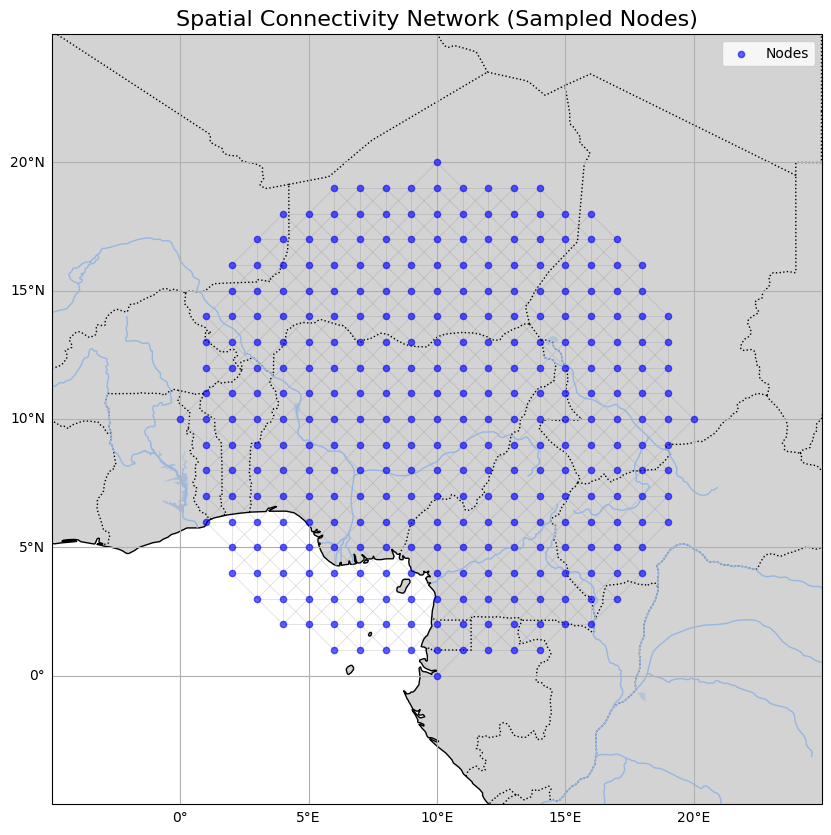

In [10]:
# Plot the connectivity on a real geographical map
plot_spatial_connectivity(
    connectivity=sub_connectivity,
    metadata=sub_metadata,
    center_lon=central_lon,
    center_lat=central_lat,
    radius=sampling_radius
)


In [11]:
import torch

torch.save(connectivity, "soil-water-forecasting/modeling-pipeline/data/05_model_input/connectivity.pt")

In [12]:
import torch

connectivity = torch.load("soil-water-forecasting/modeling-pipeline/data/05_model_input/connectivity.pt")

/tmp/ipykernel_160129/3741746759.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  connectivity = torch.load("soil-water-forecasting/modeling-pipeline/data/05_model_input/